In [1]:
# la creation dun model pour la prediction des sentiment

In [27]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
#  Modelisation avec l'algorithme Random forest ...
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree     import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# chargement des modules specifiques au mining
from spellchecker import SpellChecker
from textblob import TextBlob
from langdetect import detect 
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import pymongo
import nltk
import pickle
from sklearn.ensemble import VotingClassifier
from nltk.sentiment import SentimentIntensityAnalyzer

**il faut commencer par la préparation des données textuelles:**
- Etape 1: Utilisation des expressions régulières  pour supprimer les ponctuations 
- Etape 2 : Transformer le text vers des caractères minuscules 
- Etape 3: Division/Splitting de la phase en entités 
- Etape 4 : Suppression des stop words à l'aide du module nltk et tokenisation des mots
- Etape 5 :Construction d'un corpus 
- Etape 6 : Encodage numérique du corpus text

In [2]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["Social_listning1"]
mycol = mydb["Post_Comments"]
mycol2 = mydb["vaccine_tweets"]

In [3]:
df = pd.DataFrame()
j = 0
for i in mycol2.find({},{'tweet':1, 'language': 1,"_id":0}):
    df.loc[j, 'tweet']    = i['tweet']
    df.loc[j, 'language'] = i['language']
    j+=1

In [4]:
df

,tweet,language
0,To all staff in @nhsuhcw who haven’t yet had t...,en
1,WA | BE COVID VACCINE READY #Covid19 #WA #vaccine,en
2,"As the rollout of the COVID-19 vaccine begins,...",en
3,#AntibodyDependentEnhancement means that the #...,en
4,I got the COVID vaccine today. No side effects...,en
...,...,...
2695,ELI LILLYS ANTBODY VACCINE IS A GO! https://t...,en
2696,@narendramodi @JustinTrudeau Khalistan or Covi...,en
2697,Johnson &amp; Johnson CEO says people will nee...,en
2698,So....got my 1st Covid vaccine...whawhat. ...a...,en


In [5]:
liste_ind=[]
for i in mycol.find():
    liste_ind.append(i['Post_Caption'])
    for j in i['Post_Comments']:
        liste_ind.append(j)

In [ ]:
j = 2700
for i in liste_ind:
    try:
        df.loc[j, 'tweet']    = i
        df.loc[j, 'language'] = detect(i)
        j+=1
    except:
        print(i)

In [8]:
df['language'].unique()

array(['en', 'de', 'pt', 'und', 'fr', 'es', 'tl', 'da', 'in', 'cy', 'nl',
       'ca', 'it', 'sk', 'id', 'hr', 'tr', 'so', 'pl', 'no', 'sq', 'vi',
       'af', 'et', 'sw', 'ro', 'fi', 'sl', 'sv', 'cs', 'hu', 'lt', 'uk',
       'lv', 'ru', 'ar', 'ja', nan], dtype=object)

In [12]:
spell = SpellChecker()
corpus1 = []
for i in range(len(df[['tweet','language']])):
    try:
        review = df['tweet'][i]
        if df['language'][i] != 'en':
            review = GoogleTranslator(source='auto', target='en').translate(review)
        review = re.sub( "http\S+"," ", review )
        review = re.sub( "@\w*"," ", review )
        review = re.sub( "[^A-Za-z]"," ", review )
        review = review.lower()
        review = review.split()
        review = [spell.correction(word) for word in review ]
        review = ' '.join(review)
        corpus1.append(review)
    except:
         pass 

In [14]:
len(corpus1)

14461

In [22]:
sia = SentimentIntensityAnalyzer()
df_class = pd.DataFrame()
try:
    for i in range(len(corpus1)):
        compound = sia.polarity_scores(corpus1[i])['compound']
        neu_sent = sia.polarity_scores(corpus1[i])['neu']
        if neu_sent == 1:
            df_class.loc[i,'Review'] = corpus1[i]
            df_class.loc[i,'Liked'] = 0
        elif compound > 0  :
            df_class.loc[i,'Review'] = corpus1[i]
            df_class.loc[i,'Liked'] = 1
        else :
            df_class.loc[i,'Review'] = corpus1[i]
            df_class.loc[i,'Liked'] = -1
except:
    pass

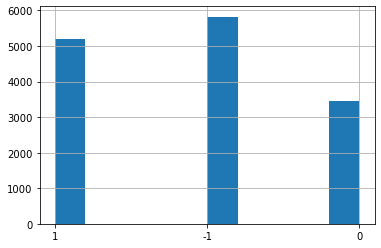

In [24]:
# 0 c-a-d neutre, 1 c-a-d positif, -1 c-a-d negatif
df_class['Liked'].hist();

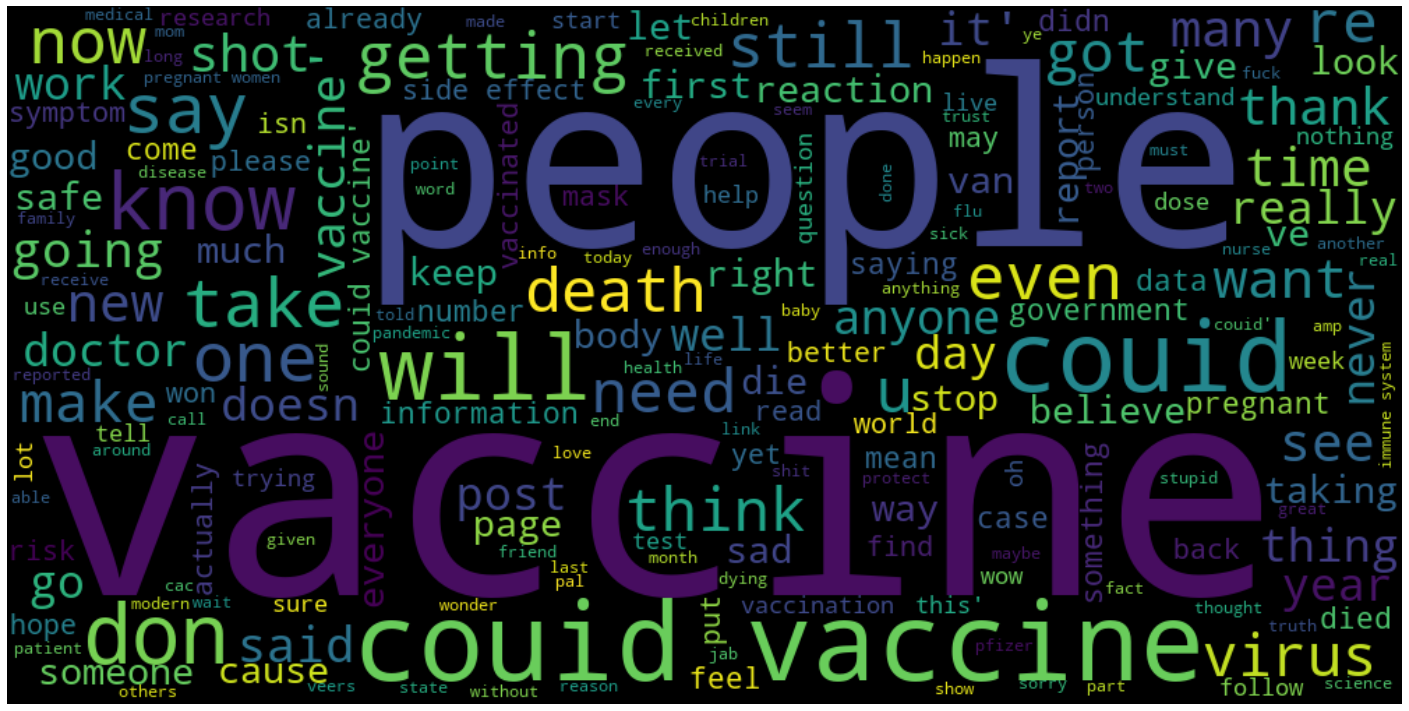

In [34]:
# pour savoir les sujets de jeu de donnee

words = set(STOPWORDS)
words.add("https")
words.add("xa0")
words.add("xa0'")
words.add("bitly")
words.add("bit")
words.add("ly")
words.add("twitter")
words.add("pic")
wordcloud = WordCloud(
    background_color = 'black',
    width = 1000,
    height = 500,
    stopwords = words).generate(str(corpus1))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.rcParams["figure.figsize"] = [20, 25]

In [39]:
corpus=[]
for i in range(len(df_class['Review'])):
    review = df_class['Review'][i]
    review = review.lower()
    review = review.split()
    ps     = PorterStemmer()
    review = [ps.stem(word) for word in review if word not  in set(stopwords.words("english"))]
    review = ' '.join(review)
    df_class.loc[i, 'Review'] = review

In [40]:
df_class

,Review,Liked
0,staff yet couid vaccin consid good reason jab ...,1
1,wa couid vaccin readi couid wa vaccin,1
2,rollout couid vaccin begin mani peopl question...,1
3,antibodydependentenhanc mean couid vaccin actu...,-1
4,got couid vaccin today side effect yet except ...,1
...,...,...
14456,vaccin passport would creat discrimin peopl ca...,1
14457,care alreadi violat right forc lockdown arrest...,-1
14458,reason say modern opt provid south africa bill...,-1
14459,tyranni care control end game,1


In [42]:
cv = CountVectorizer()
X = cv.fit_transform(df_class['Review']).toarray()

In [45]:
y = df_class.iloc[:,-1]

In [46]:
x_train, x_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state = 1)

In [47]:
rf = RandomForestClassifier(n_estimators=1000)
lr = LogisticRegression()
nb = GaussianNB()
df = DecisionTreeClassifier()
svm = SVC(kernel='sigmoid')

In [48]:
evc = VotingClassifier(estimators=[('lr',lr), ('df',df), ('svm',svm), ('nb',nb), ('rf',rf)],voting='hard',n_jobs=3)

In [49]:
evc.fit_transform(x_train, y_train)

array([[2, 2, 2, 2, 2],
       [2, 2, 0, 0, 2],
       [2, 2, 2, 2, 2],
       ...,
       [1, 1, 2, 1, 1],
       [0, 0, 2, 0, 0],
       [1, 1, 2, 1, 1]])

In [51]:
y_pred = evc.predict(x_test)

In [52]:
evc.score(x_test, y_test)

0.7646042170756999

In [58]:
nouveau_commentaire = [ "i hate this palce" ]
xx = cv.transform(nouveau_commentaire).toarray()

In [59]:
print(evc.predict(xx))

['-1']


In [60]:
nouveau_commentaire = [ "wow, amazing" ]
xx = cv.transform(nouveau_commentaire).toarray()

In [61]:
print(evc.predict(xx))

['1']


In [57]:
nouveau_commentaire = [ "i go to school" ]
xx = cv.transform(nouveau_commentaire).toarray()
print(evc.predict(xx))

['0']


In [66]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(evc, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
print(loaded_model.predict(xx))

['1']
